In [2]:
import numpy as np
import cvxopt
from sklearn import datasets
from matplotlib import pyplot as plt

In [3]:
# 隐藏 cvxopt 输出
cvxopt.solvers.options['show_progress'] = False


def linear_kernel(**kwargs):
    def f(x1, x2):
        return np.inner(x1, x2)

    return f


def polynomial_kernel(power, coef, **kwargs):
    def f(x1, x2):
        return (np.inner(x1, x2) + coef) ** power

    return f


def rbf_kernel(gamma, **kwargs):
    def f(x1, x2):
        distance = np.linalg.norm(x1 - x2) ** 2
        return np.exp(-gamma * distance)

    return f


class SupportVectorMachine():

    def __init__(self, kernel=linear_kernel, power=4, gamma=None, coef=4):
        self.kernel = kernel
        self.power = power
        self.gamma = gamma
        self.coef = coef
        self.lagr_multipliers = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.intercept = None


    def fit(self, X, y):
        n_samples, n_features = np.shape(X)  # gamma 默认设置为 1 / n_features if not self.gamma:
    
        self.gamma = 1 / n_features  # 定义核函数
        self.kernel = self.kernel(
            power=self.power,
            gamma=self.gamma,
            coef=self.coef)
        # 计算 Gram 矩阵
        kernel_matrix = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                kernel_matrix[i, j] = self.kernel(X[i], X[j])  # 构造二次规划问题
        # 形式为 min (1/2)x.T*P*x+q.T*x, s.t. G*x<=h, A*x=b
        P = cvxopt.matrix(np.outer(y, y) * kernel_matrix, tc='d')
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples), tc='d')
        b = cvxopt.matrix(0, tc='d')
        G = cvxopt.matrix(np.identity(n_samples) * -1)
        h = cvxopt.matrix(np.zeros(n_samples))
        # 用 cvxopt 求解二次规划问题
        minimization = cvxopt.solvers.qp(P, q, G, h, A, b)
        lagr_mult = np.ravel(minimization['x'])
        # 非 0 的 alpha 值
        idx = lagr_mult > 1e-7
        # alpha 值
        self.lagr_multipliers = lagr_mult[idx]
        # 支持向量
        self.support_vectors = X[idx]
        # 支持向量的标签
        self.support_vector_labels = y[idx]
        # 通过第一个支持向量计算 b
        self.intercept = self.support_vector_labels[0]
        for i in range(len(self.lagr_multipliers)):
            self.intercept -= self.lagr_multipliers[i] * self.support_vector_labels[
                i] * self.kernel(self.support_vectors[i], self.support_vectors[0])

    def predict(self, X):
        y_pred = []
        for sample in X:
            # 对于输入的 x, 计算 f(x)
            prediction = 0
            for i in range(len(self.lagr_multipliers)):
                prediction += self.lagr_multipliers[i] * self.support_vector_labels[
                    i] * self.kernel(self.support_vectors[i], sample)
            prediction += self.intercept
            y_pred.append(np.sign(prediction))
        return np.array(y_pred)

    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.sum(y == y_pred, axis=0) / len(y)
        return accuracy

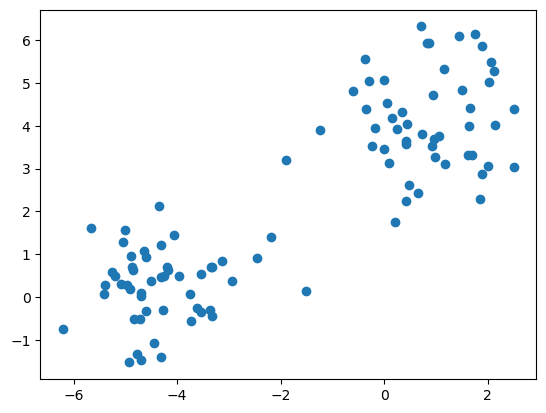

In [4]:
# 测试用例
X, y = datasets.make_blobs(n_samples=100, centers=2, random_state=3)
y[y == 0] = -1
y[y == 1] = 1
plt.scatter(X[:, 0], X[:, 1])

In [5]:
model = SupportVectorMachine()
model.fit(X, y)
print(model.predict([np.array([-0.4, -0.5])]))
print(model.predict([np.array([2.6, 5.3])]))

[1.]
[-1.]


In [6]:
model = SupportVectorMachine()
model.fit(X, y)
print(model.predict([np.array([-0.4, -0.5])]))
print(model.predict([np.array([2.6, 5.3])]))

[1.]
[-1.]
